# Define API keys and libraries

In [3]:
import json
import requests
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from PIL import Image, ImageDraw, ImageFont

In [4]:
api_key = 'da56733a-6d62-4da1-9d2f-4e882d46478b'

# Define functions for calling API endpoints

In [5]:
class api_511:
    
    def __init__(self, api_key):
        self.api_key = api_key
    
    def get_request(self, url, params):
        response = requests.get(
            url = url,
            params = {
                'api_key': self.api_key,
                **params
            }
        )
        decoded = response.content.decode('utf-8-sig') # strip byte order mark from response
        return json.loads(decoded)
    
    def get_stops(self, operator_id='SF'):
        response = self.get_request(
            url = 'http://api.511.org/transit/stops',
            params = {
                'format': 'json',
                'operator_id': operator_id
            }
        )
        stop_list = response['Contents']['dataObjects']['ScheduledStopPoint']
        stop_df = pd.DataFrame([
            {
                'stop_id': d['id'],
                'name': d['Name'],
                'longitude': d['Location']['Longitude'],
                'latitude': d['Location']['Latitude'],
                'url': d['Url'],
                'stop_type': d['StopType']
            } for d in stop_list
        ])
        
        return stop_df
    
    def get_stop_monitoring(self, stop_code, operator_id='SF'):
        response = self.get_request(
            url = 'http://api.511.org/transit/StopMonitoring',
            params = {
                'format': 'json',
                'agency': operator_id,
                #'route': route,  doesn't seem to make any difference
                'stopCode': stop_code
            }
        )
        
        monitor_list = response['ServiceDelivery']['StopMonitoringDelivery']['MonitoredStopVisit']
        monitor_df = pd.DataFrame([
            {
                'timestamp': d['RecordedAtTime'],
                'line': d['MonitoredVehicleJourney']['LineRef'],
                'line_name': d['MonitoredVehicleJourney']['PublishedLineName'],
                'origin_stop_id': d['MonitoredVehicleJourney']['OriginRef'],
                'origin_stop_name': d['MonitoredVehicleJourney']['OriginName'],
                'destination_stop_id': d['MonitoredVehicleJourney']['DestinationRef'],
                'destination_stop_name': d['MonitoredVehicleJourney']['DestinationName'],
                'monitored_stop_id': d['MonitoredVehicleJourney']['MonitoredCall']['StopPointRef'],
                'monitored_stop_name': d['MonitoredVehicleJourney']['MonitoredCall']['StopPointName'],
                'is_monitored': d['MonitoredVehicleJourney']['Monitored'],
                'vehicle_longitude': d['MonitoredVehicleJourney']['VehicleLocation']['Longitude'],
                'vehicle_latitude': d['MonitoredVehicleJourney']['VehicleLocation']['Latitude'],
                'aimed_arrival_time': d['MonitoredVehicleJourney']['MonitoredCall']['AimedArrivalTime'],
                'expected_arrival_time': d['MonitoredVehicleJourney']['MonitoredCall']['ExpectedArrivalTime'],
            } for d in monitor_list
        ])
        
        return monitor_df

In [6]:
api = api_511(api_key)

In [7]:
#Create a dictionary of relevant stops
stops_dict = {
    'portola' : '16121', # Portola Dr & Teresita Blvd
    'lh' : '15255', #Laguna Honda & Ulloa
    'lh_to_hp' : '15254', # 43 going the other way
    'oshaughn' : '15834', # 44 going the other way
    'portola_lh' : '16113',
    'woodside' : '16937', #Woodside towards Forest Hill
    'woodsied_to_gp' : '16938', #Woodside towards Glen Park
    'evelyn' : '16669', #Evelyn Way towards Forest Hill
    'evelyn_to_gp' : '16665' #Evelyn Way towards Glen Park/Mission

}

# Define functions to select relevant routes and information

In [66]:
def format_time_delta(delta: timedelta) -> str:
    seconds = int(delta.total_seconds())
    secs_in_a_min = 60
    minutes, seconds = divmod(seconds, secs_in_a_min)
    time_fmt = f"{minutes}" + " min " f"{seconds:02d}" + " secs" #f"{minutes}:{seconds:02d}"
    return time_fmt

In [9]:
def format_time(df, row, col):
    time = datetime.strptime(re.subn('[T]', ' ', df.at[row,col])[0].replace('Z',''),'%Y-%m-%d %H:%M:%S')
    return time

In [10]:
def display_stop(df):
    for i in range(df.shape[0]):
        #Some reformatting of objs/strings in df to be in datetime format
        timestamp = format_time(df, 0, 'timestamp')
        first_arrival = format_time(df, i, 'expected_arrival_time')
        first_line = df.at[i,'line']
        direction = df.at[i, 'destination_stop_name']
        delta = first_arrival - timestamp
        if(delta < timedelta(minutes=25)):
            print(format_display_time(delta, first_line, direction))

In [11]:
def filter_by_time(df):
    delta = []
    for i in range(df.shape[0]):
        #Some reformatting of objs/strings in df to be in datetime format
        timestamp = format_time(df, 0, 'timestamp')
        first_arrival = format_time(df, i, 'expected_arrival_time')
        first_line = df.at[i,'line']
        direction = df.at[i, 'destination_stop_name']
        delta.append(first_arrival - timestamp)
    df["time_till_departure"] = delta
    twentyfive = timedelta(minutes = 60)
    df.sort_values(['line','destination_stop_name'], inplace=True, ignore_index=True)
    return df.reset_index(drop = True)
    #return df.loc[df['time_till_departure'] < twentyfive].reset_index(drop = True)

In [357]:
def relevant_format(df):
    df = filter_by_time(df)
    pivot_df = pd.pivot_table(df, values = "time_till_departure", index=["line","destination_stop_name"], columns=df.groupby(['line',"destination_stop_name"]).cumcount())
    pivot_df.columns = [f"Arrival {i}" for i in range(1, len(pivot_df.columns)+1)]
    pivot_df = pivot_df.reset_index()
    pivot_df = pivot_df.rename(columns={'line': 'Route', 'destination_stop_name': 'Destination', 'Arrival 1': 'Next Arrival'})
    pivot_df = pivot_df.applymap(lambda x: format_time_delta(x) if isinstance(x, timedelta) else x)
    pivot_df = pivot_df.fillna("No Next Arrival")
    pivot_df = pivot_df.replace("Bayview District - Hudson & Newhall", 'Bayview')
    routes = pivot_df['Route'].tolist()
    destinations = pivot_df['Destination'].tolist()
    column_names=['Route', 'Destination', 'Next Arrival', '2nd Arrival', '3rd Arrival']
    empty_cols = pd.DataFrame(columns=column_names[2:])          
    clean_df = pd.DataFrame({'Route':routes, 'Destination': destinations})
    clean_df = pd.concat([clean_df, empty_cols], axis=1)
    clean_df[['Next Arrival', '2nd Arrival', '3rd Arrival']] = \
        pivot_df.loc[:, ~pivot_df.columns.isin(['Route', 'Destination'])].iloc[:, :3].values
    # print(clean_df)
    return clean_df

# Define function to create image for display

In [352]:
def make_image(df):
    #Set the fonts and header size
    font_size = 18
    font= ImageFont.truetype('/fonts/DIN Alternate Bold.ttf', font_size)
    font_header = ImageFont.truetype('/fonts/SFCompact.ttf', 20)
    font_route = ImageFont.truetype('/fonts/SFCompact.ttf', 35)
    padding = 10
    header_space = 60

    # def max_bbox(cell, direction):
    #     # cell_cord = font_data.getbbox(cell, stroke_width=1)
    #     # if direction == 'width':
    #     #     return cell_cord[2]-cell_cord[0]
    #     # else:
    #     #     return cell_cord[3] - cell_cord[1]

    # Create the image
    image_width = 800
    image_height = 480 
    image = Image.new("RGB", (image_width, image_height), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)

    # Calculate the width and height of each cell
    cell_width = image_width/5
    #cell_width = (df.applymap(lambda x: max_bbox(x, 'width'))).to_numpy().max()
    cell_height = ((image_height - header_space)/(len(df))) #need to figure this part out
    #cell_height = (df.applymap(lambda x: max_bbox(x, 'height'))).to_numpy().max()

    # Draw the table headers
    x = 0
    y = 0
    for header in df.columns:
        draw.rectangle((x, y , x + cell_width, y + header_space), fill=(194, 136, 74), outline=(0, 0, 0))
        draw.text((x + padding, y + padding), header, font=font_header, fill=0)
        x += cell_width  # adjust the column width

    #Draw the rows with destination and times.  Loops through rows first
    for i, row in df.iterrows():
        x = 0
        for j, val in enumerate(row):
            y = (cell_height) * (i) +header_space
            if j >= 1:
                if i%2 == 1:
                    draw.rectangle((x, y , x + cell_width, y + cell_height), fill=(211, 211, 211), outline= (0,0,0))
                draw.text((x + 3, y + padding), str(val), font=font, fill=(0, 0, 0))
            elif i%2 == 1: #The first column
                draw.rectangle((x, y - cell_height, x + cell_width, y + cell_height*2), fill=(150, 94, 209), outline=(0, 0, 0))
                draw.text((x + 15, y - padding), str(val), font=font_route, fill=(0, 0, 0))
                draw.line((x + cell_width - 1 ,y - cell_height, x + cell_width - 1,y+(cell_height*2)), fill=(0,0,0), width=3)
            x += cell_width
            # Draw vertical lines between columns
            draw.line((x ,y , x ,y+(cell_height*2)), fill=(0,0,0), width=1)
    #line separating headers from data
    draw.line((0, header_space, image_width, header_space), fill=(0, 0, 0), width=10)
    
    # save the image
    image.save("test.png")
    # return the image
    return image

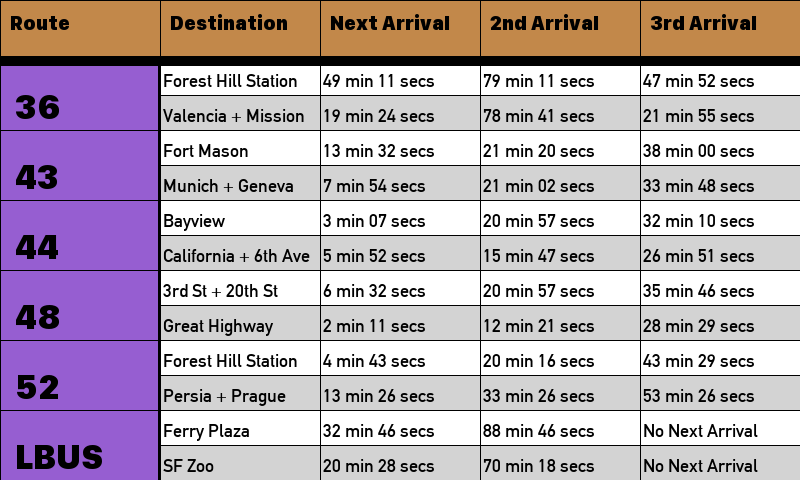

In [354]:
make_image(relevant_df)

# Run relevant functions

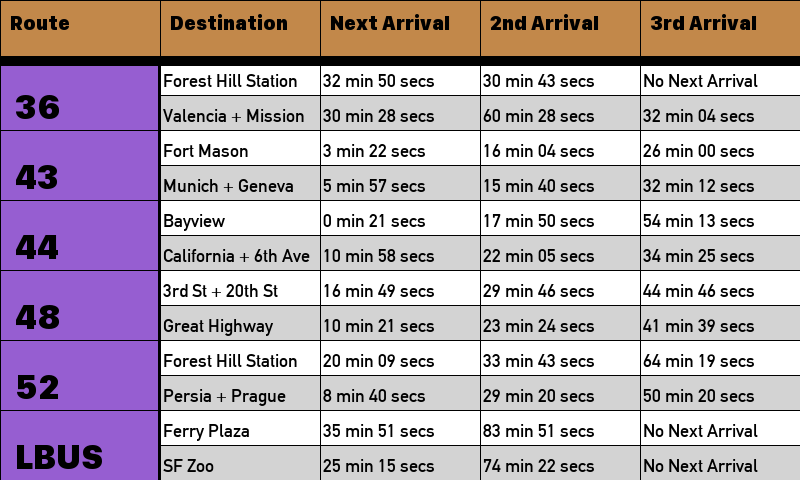

In [358]:
local_df = pd.DataFrame()
for values in stops_dict.values():
    local_df = pd.concat([local_df, api.get_stop_monitoring(values)], ignore_index=True)
relevant_df = relevant_format(local_df)
make_image(relevant_df)